## Part2: Decision Trees
In this exercise we explore K-means clustering - and we it out on the locations of the PROSTITUTION crime type. Applying a clustering method makes sense because we know from our earlier work that this crime type tends to happen in only a few locations. We'll also talk a little bit about model selection and overfitting in unsupervised models.
### K-means
#### Visualize the prostitution data (e.g. by plotting it on a map)

We are ready to load the data into a pandas dataframe. We only need the 3 attributes; Category, X and Y. Note that we filter everything that is not in target category "PROSTITUTION". We also set a random seed.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(seed=1337)

categories = ["Category", "X", "Y"]

# Load the data into a pandas dataframe
df = pd.read_csv('../data/Map__Crime_Incidents_-_from_1_Jan_2003.csv', header=0, usecols = categories)

# Filter the data on the categories which we focus on
df = df.loc[df['Category'].isin(["PROSTITUTION"])]

We import geolib and plot the data

In [2]:
import geoplotlib 

# Create our geo data
geo_data_for_plotting = {"lat": df['Y'].tolist(),
                         "lon": df['X'].tolist()}

# The coordinates have been found by spectating SF on google maps
bbox = geoplotlib.utils.BoundingBox(north=37.816286, west=-122.528583, south=37.702286, east=-122.347652)
geoplotlib.set_bbox(bbox)
geoplotlib.dot(geo_data_for_plotting, color = 'b')
geoplotlib.inline()

The dataset has an two outliers with coordinates not in San Francisco. We remove these.

In [3]:
lat = geo_data_for_plotting["lat"] 
lon = geo_data_for_plotting["lon"]

# Remove outlier 
# Hacks method not nice
for i in range(0,len(lat) - 2 ):
    if lat[i] > 80:
        print "Found an outlier"
        del lon[i]
        del lat[i]
        

Found an outlier
Found an outlier


We import needed libraries

In [4]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

We train on k=3 and visualize to see the result

In [5]:
# The data needs to be in correct format
X = np.column_stack((lat, lon))

model = KMeans(n_clusters=3)
y_pred = model.fit(X)
Z = model.labels_

# Need these arrays for the plotting
lat = np.asarray([i[0] for i in X])
lon = np.asarray([i[1] for i in X])

bbox = geoplotlib.utils.BoundingBox(north=37.816286, west=-122.528583, south=37.702286, east=-122.347652)

col = ["r","b","k"]

for i in range(0,3):
    predictions = {"lat" : lat[np.where(Z == i)], "lon" : lon[np.where(Z == i)]}
    geoplotlib.set_bbox(bbox)
    geoplotlib.dot(predictions, color = col[i])

geoplotlib.tiles_provider('watercolor')
geoplotlib.inline(width=750)

#### Train models of K=2,…,10 on the prostitution data.
** Explore how the total squared error changes as a function of K and identify what you think is the right number of clusers based on the knee-point in the squared error plot. **

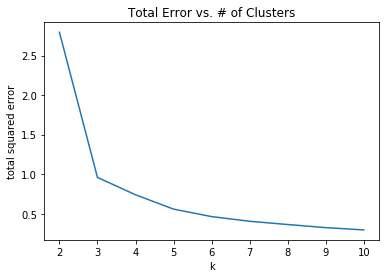

In [6]:
# Compute squared error
# Use functions from book
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def vector_subtract(v, w):
    """subtracts corresponding elements"""
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v, w):
    """(v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(vector_subtract(v, w))

# I use the function from the text-book slightly modified
def squared_clustering_errors(k):
    """ finds the total squared error from k-means clustering the inputs """
    model = KMeans(n_clusters=k)
    model.fit(X)
    centroids = model.cluster_centers_
    assignments = model.labels_

    return sum(squared_distance(data_point, centroids[cluster])
               for data_point, cluster in zip(X, assignments))


# now plot from 2 up to 10 clusters
ks = range(2, 11)

errors = [squared_clustering_errors(k) for k in ks]
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

** And by the way: The fit only gets better when we add more means - why not keep adding more of them: Explain in your own words why it makes sense to stop around a knee-point. **

Simple. Of course the total squared error will keep diving as more centroids/means are added. This is because some points will obviously be closer to the added centroids. However, the gains are so small which could indidcate that we already captured the clusters which are relevant. Judging from the plot, we should settle with 3-5 clusters. It is hard to see what exactly is the best, but the huge fall from 2-3 could indicate that 3 is optimal. 



** Another analysis **

Another way of estimating the right number of clusters in a KK-means problem is stability analysis. The idea is the following

* For each K=2,…,10K=2,…,10 generate N=10N=10 clusterings based on random 50% of data (or some other fraction of data/bootstrap).

* Divide the space up into an e.g. 20 by 20 grid, and give each gridpoint an index ii in the range 1-400.

* Now represent each clustering as a vector cKcK, which where the jjth entry cKjcjK is given by the number of centroids in that gridpoint. Most of the entries will be zero, and we have that ∑400j=1cKj=K∑j=1400cjK=K.

* We now define stability for some value of KK as average pairwise similarity of the NN clusterings, where the similarity between clustering ii and jj is the cosine distance between clustering vectors cK(i)cK(i) and cK(j)cK(j).

We now say that the right KK maximizes stability.

** Explain why stability should help you find the right number of clusters. **

Since we choose the number of clusters as where the K-means is most stable. We get a lot of different datasets which are subsets, and base our k value on where it is most stable. 